## LLM  Part 6 :  Self Attention with Trainable Weights 

**Reference text** 

https://www.manning.com/books/build-a-large-language-model-from-scratch

**Text Corpus** 

The text we will tokenize for LLM training is a short story by Edith Wharton called The Verdict, which has been released into the public domain and is thus permitted to be used for LLM training tasks. The text is available on Wikisource at https://en.wikisource.org/wiki/The_Verdict,



##  Objective 

In this notebook, we will be implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other LLM's. This self-attention mechanism is also called scaled dot- product attention.


**Key Points**

- The self-attention mechanism with trainable weights builds on the previous concepts: we want to compute context vectors as weighted sums over the input vectors specific to a certain input element. 

- As you will see, there are only slight differences compared to the basic self- attention mechanism we coded earlier in last post - Notebook 5 

- The most notable difference is the introduction of weight matrices that are updated during model training. 

##  Computing Attention Weights Step by Step 


**Key Notes**

- We will implement the self-attention mechanism step by step by introducing the three trainable weight matrices 

$ W_q, W_k,$ and $ W_v. $

- These three matrices are used to project the embedded input tokens, x(i), into query, key, and value vectors


## Preliminary Step - Define Inputs - similar to Previous notebook 



In [1]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # wars     (x^1)
   [0.55, 0.87, 0.66], # not      (x^2)
   [0.57, 0.85, 0.64], # make     (x^3)
   [0.22, 0.58, 0.33], # one      (x^4)
   [0.02, 0.81, 0.52]] # great    (x^5)
)


/Users/anishroychowdhury/anaconda3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Note on Query Key Value 

The terms "key," "query," and "value" in the context of attention mechanisms are borrowed from the domain of information retrieval and databases, where similar concepts are used to store, search, and retrieve information.

**query**
- A "query" is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them.


**key**
- The "key" is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match with the query.

**value**

- The "value" in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.

### STEP 1 - Computing query (q)  , key (k) and value (v)  vectors for input elements 

**Key Notes**

- Similar to previous notebook we designate the second input, x(2), as the query input. 

- The query vector q(2) is obtained via matrix multiplication between the input x(2) and the weight matrix $ W_q $.

- Similarly, we obtain the key and value vectors via matrix multiplication involving the weight matrices $ W_k  $ and $ W_v $.



- These three matrices are used to project the embedded input tokens, $x^{(i)}$, into query, key, and value vectors via matrix multiplication:

  - Query vector: $q^{(i)} = W_q \,x^{(i)}$
  - Key vector: $k^{(i)} = W_k \,x^{(i)}$
  - Value vector: $v^{(i)} = W_v \,x^{(i)}$


- The embedding dimensions of the input $x$ and the query vector $q$ can be the same or different, depending on the model's design and specific implementation
- In GPT models, the input and output dimensions are usually the same, but for illustration purposes, to better follow the computation, we choose different input and output dimensions here:




### Refer figure below for a schematic 

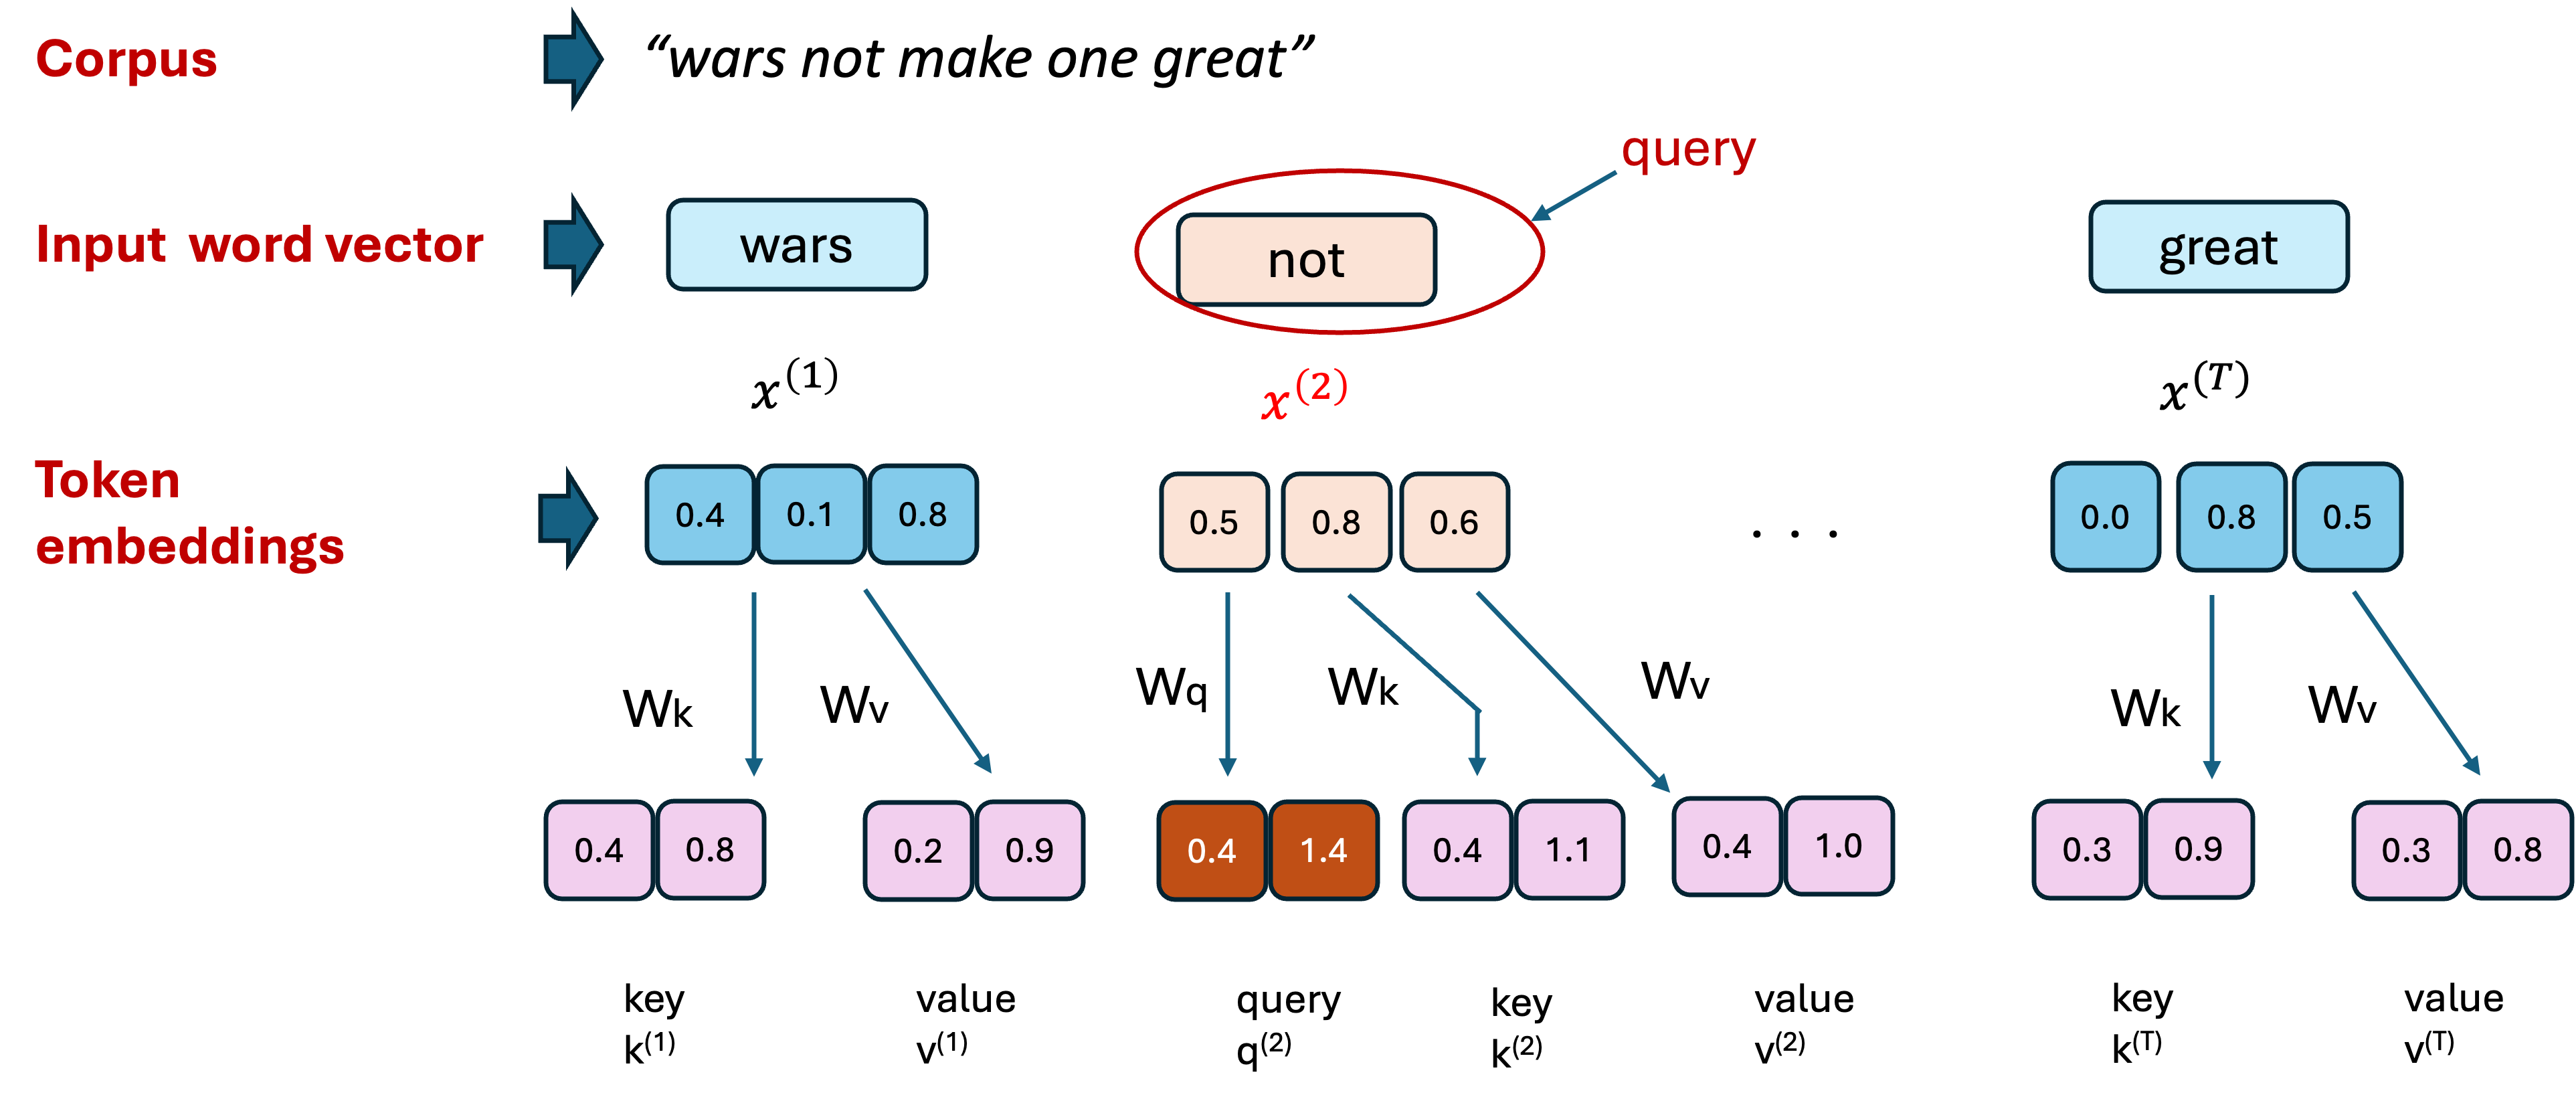

#### Step 1a - Initialize input and output embedding sizes 


In [2]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

#### Step 1b - Initialize Weight matrices

**Key Notes**

- In the code below, we initialize the three weight matrices; note that we are setting `requires_grad=False` to reduce clutter in the outputs for illustration purposes, but if we were to use the weight matrices for model training, we would set `requires_grad=True` to update these matrices during model training

####  Projecting Embeddings from 3D to 2 D

- The Schematic Below shows how the Weight Matrices Project the Embedding vectors and reduce dimensions 



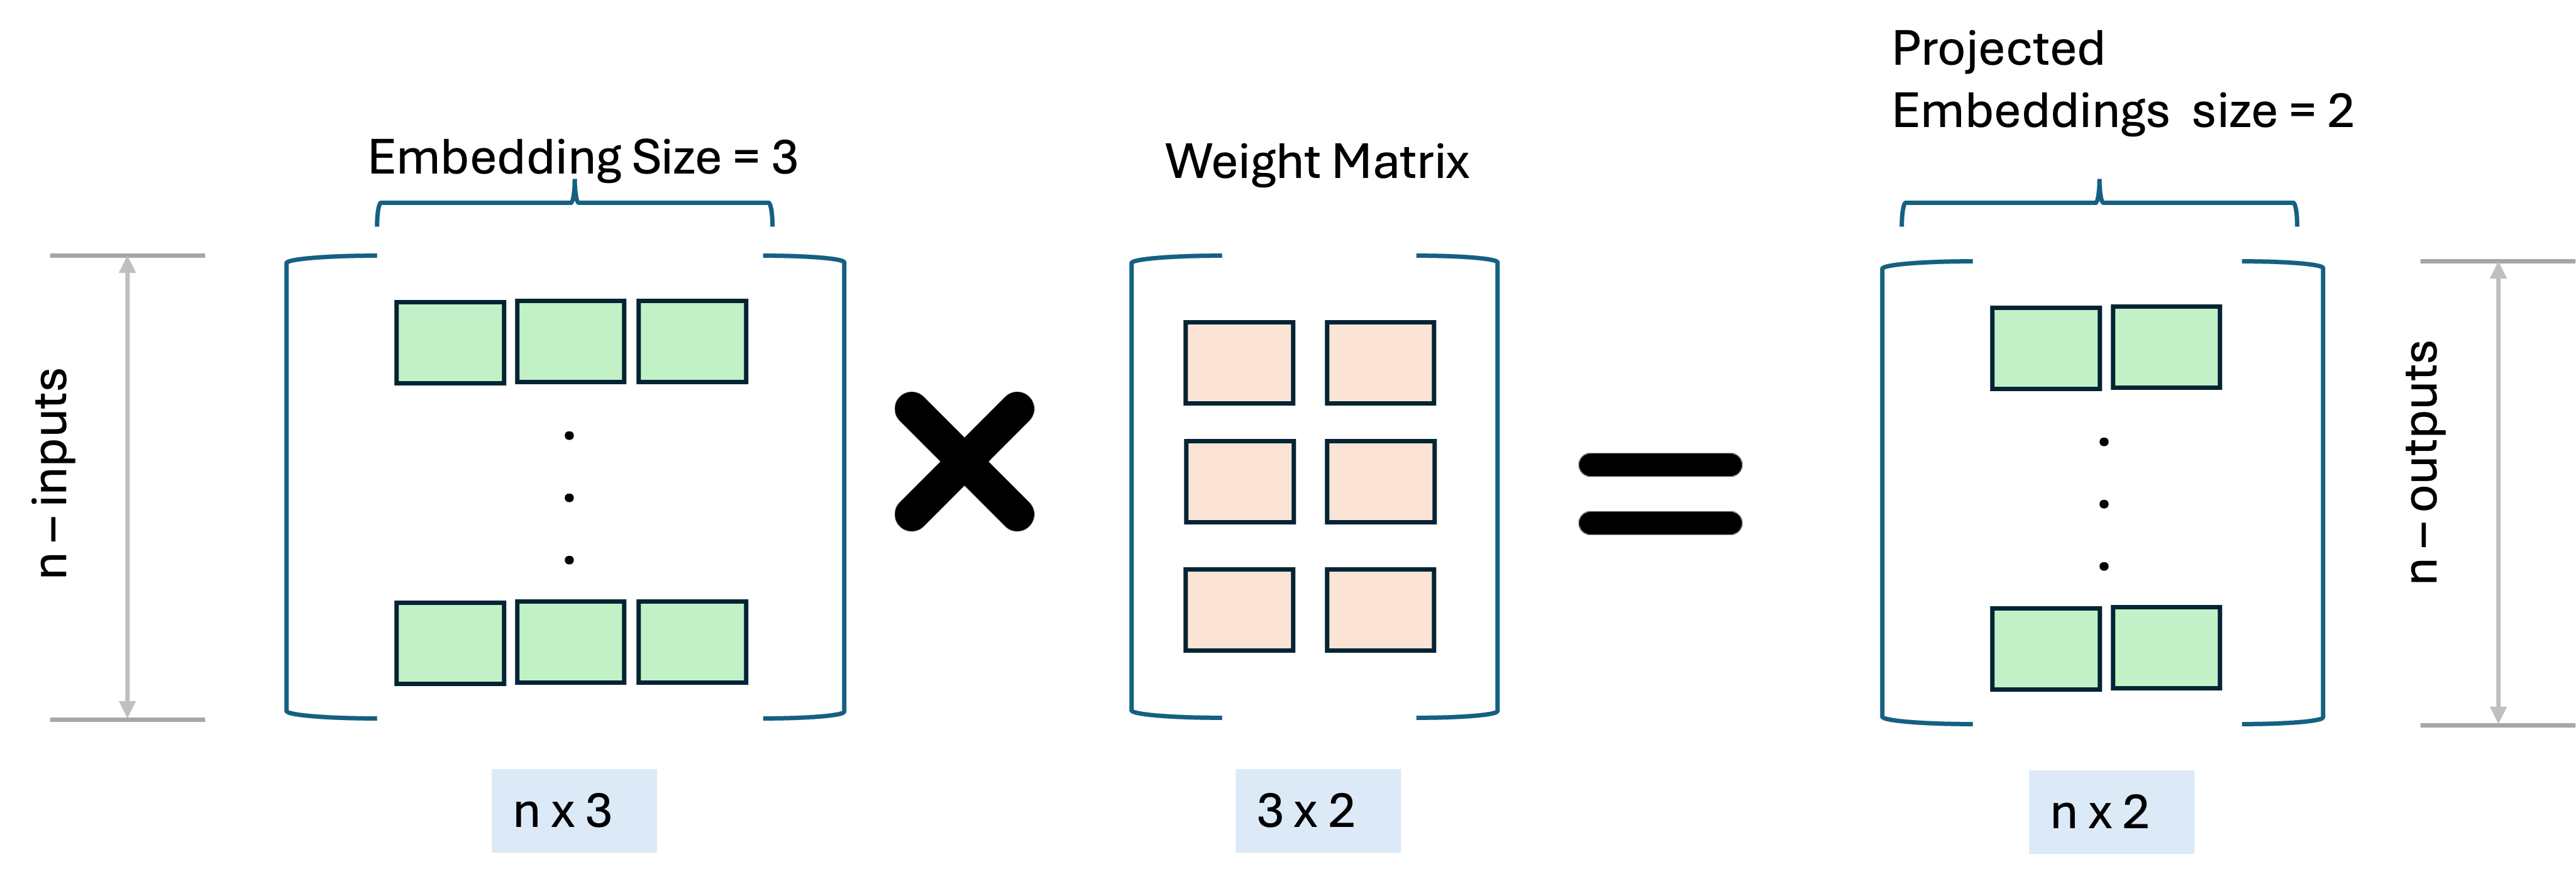

In [3]:
# first dimension 
print("First dimension is  ",d_in)

# second dimension 
print("Second dimension is ", d_out)

First dimension is   3
Second dimension is  2


In [4]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

#### Step 1 c: Compute key , query and value projections for 2nd element in input sequence 

In [5]:
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


#### Step 1 d : We can obtain all keys and values via matrix multiplication:

- This is shown schematically below 

In [6]:
keys = inputs @ W_key 
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([5, 2])
values.shape: torch.Size([5, 2])


In [7]:
# print key vectors 
print(keys)

tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.3157, 0.9478]])


In [8]:
# print value vectors 
print(values)

tensor([[0.1855, 0.8812],
        [0.3951, 1.0037],
        [0.3879, 0.9831],
        [0.2393, 0.5493],
        [0.3195, 0.7596]])


### STEP 2: compute unnormalized attention scores $\omega$


- Suppose we use the second input token as the query, that is, $q^{(2)} = W_q \,x^{(2)}$,  we compute the unnormalized attention scores via dot products:
    - $\omega_{21} = x^{(1)} q^{(2)\top}$
    - $\omega_{22} = x^{(2)} q^{(2)\top}$
    - $\omega_{23} = x^{(3)} q^{(2)\top}$
    - ...
    - $\omega_{2T} = x^{(T)} q^{(2)\top}$
- Above, $\omega$ is the Greek letter "omega" used to symbolize the unnormalized attention scores
    - The subscript "21" in $\omega_{21}$ means that input sequence element 2 was used as a query against input sequence element 1
    
    
#### Notes 
- In the case of the tensor shown above, each row represents a word, and each column represents an embedding dimension)

- The primary objective of this section is to demonstrate how the context vector $z^{(2)}$
  is calculated using the second input sequence, $x^{(2)}$, as a query

- The figure depicts the initial step in this process, which involves calculating the attention scores ω between $x^{(2)}$
  and all other input elements through a dot product operation
  
- We use input sequence element 2, $x^{(2)}$, as an example to compute context vector $z^{(2)}$; 
  
- In this  step we compute the unnormalized attention scores by computing the dot product between the query $x^{(2)}$ and all other input tokens

#### Refer Figure below for schematic of Attention Score computation 

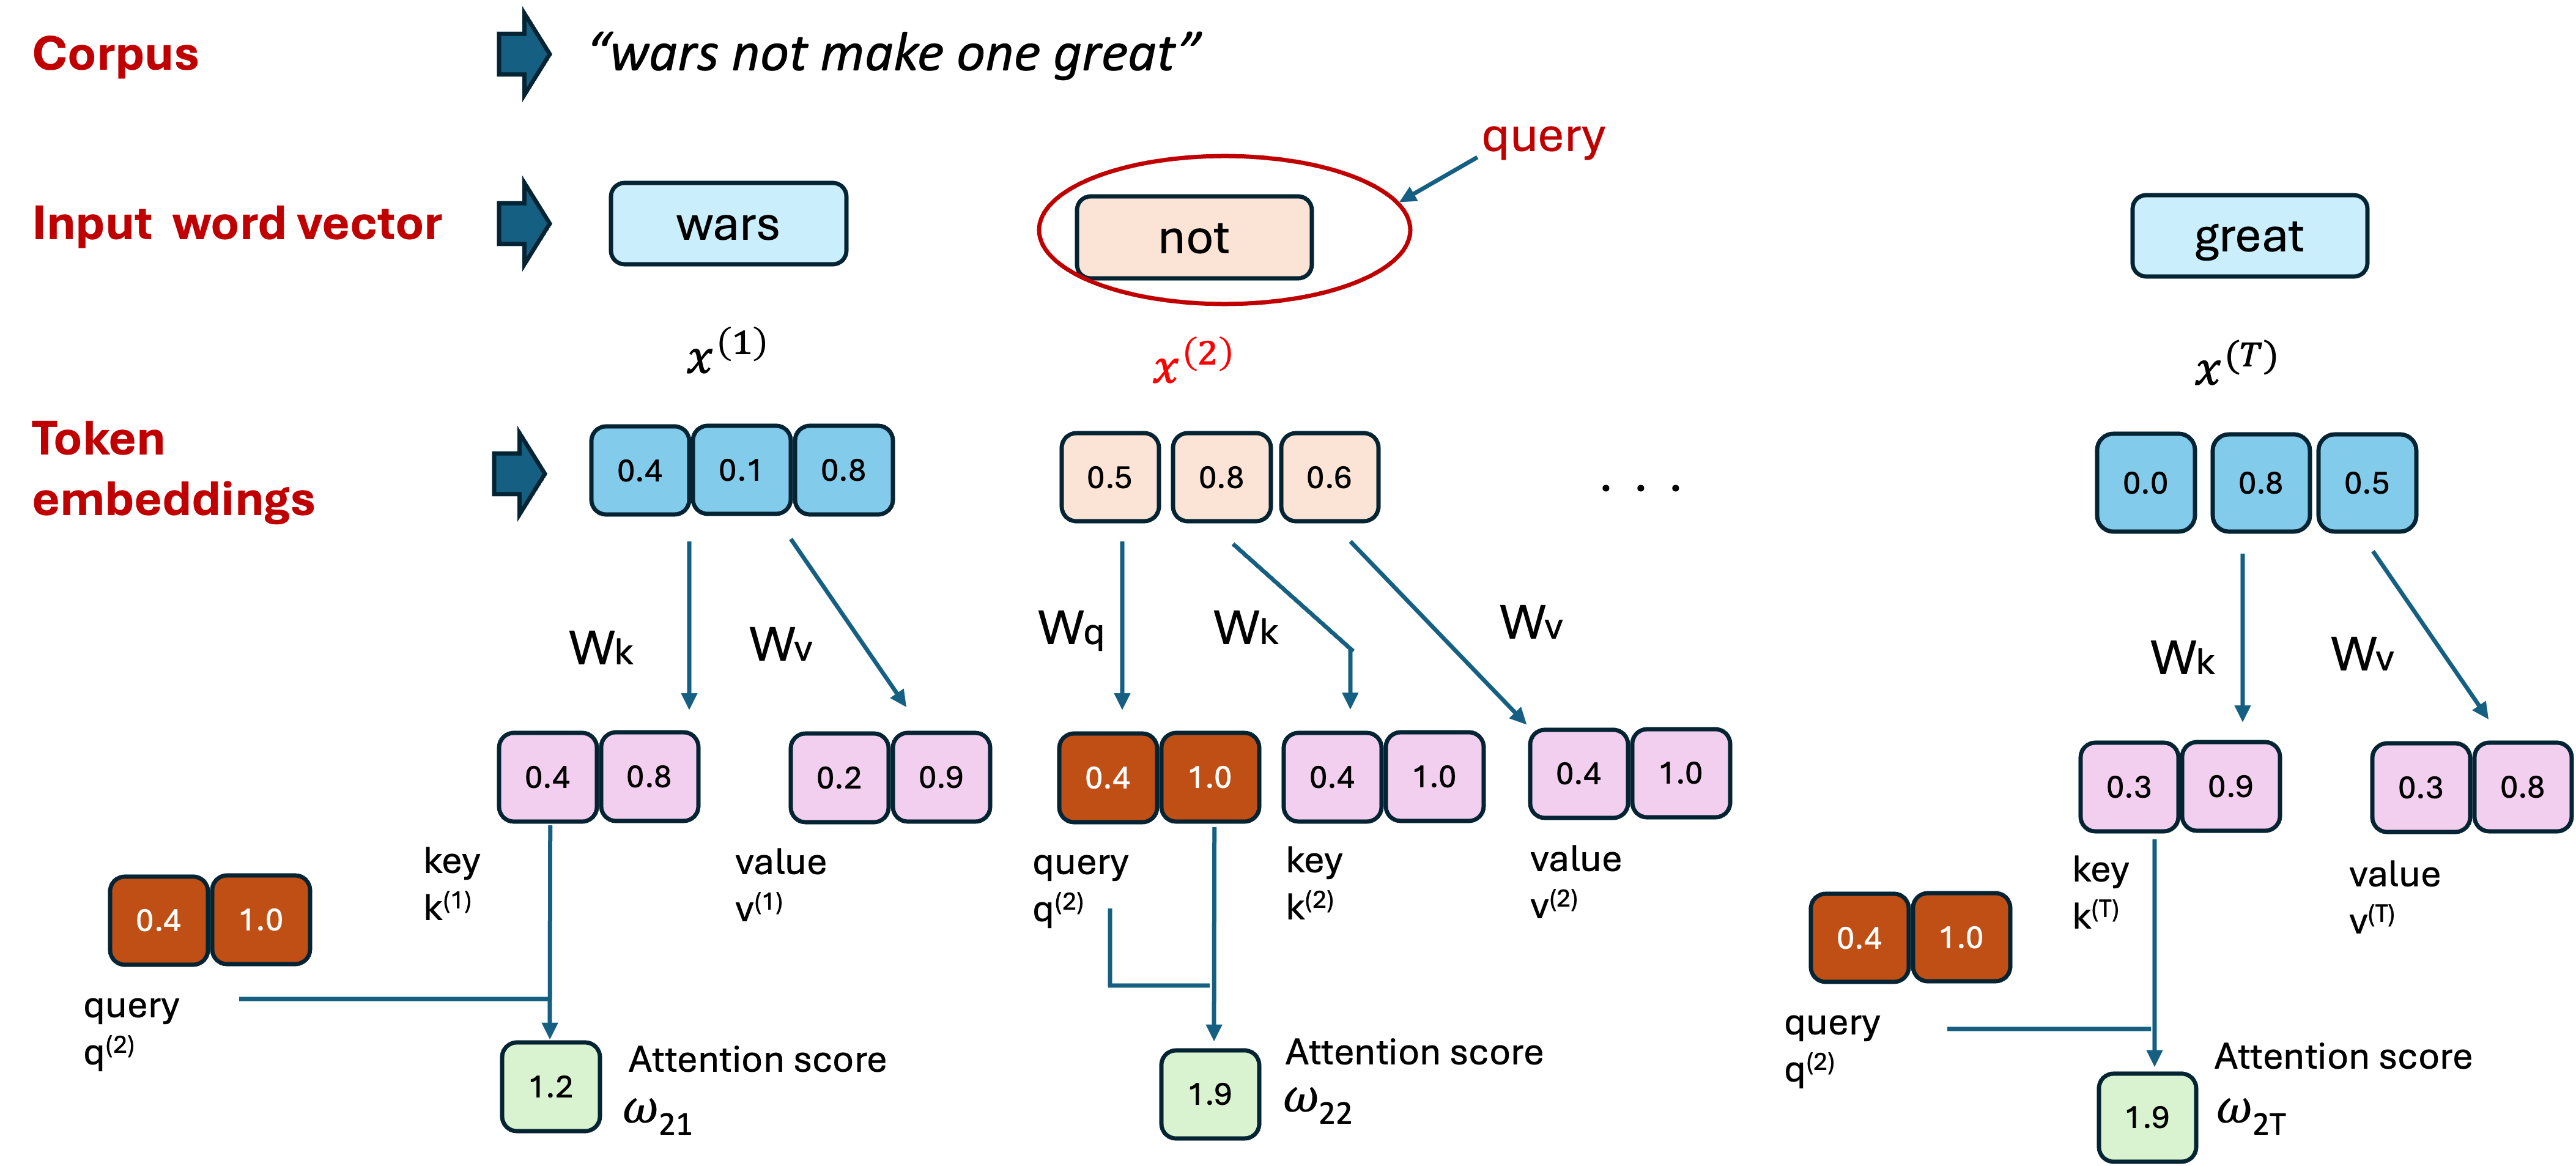

#### Step 2 a:   First, let's compute the attention score $\omega_{22}$

In [9]:
keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


#### Step 2 b:   Let us now compute all the  attention scores 

- Since we have 5 inputs, we have 5 attention scores for the given query vector:

**Check Dimensions**

In [10]:
### Check size of second query vector 
print(" Size of second query vector is :", len(query_2))

# check number of key vectors 
print(" Number of Key vectors : " , keys.shape[0])

# Size of a key vector 
print(" Size of a key vector is :" , keys.shape[1])

 Size of second query vector is : 2
 Number of Key vectors :  5
 Size of a key vector is : 2


#### Schematic showing compute of All Attention scores wrt 2nd query vector 


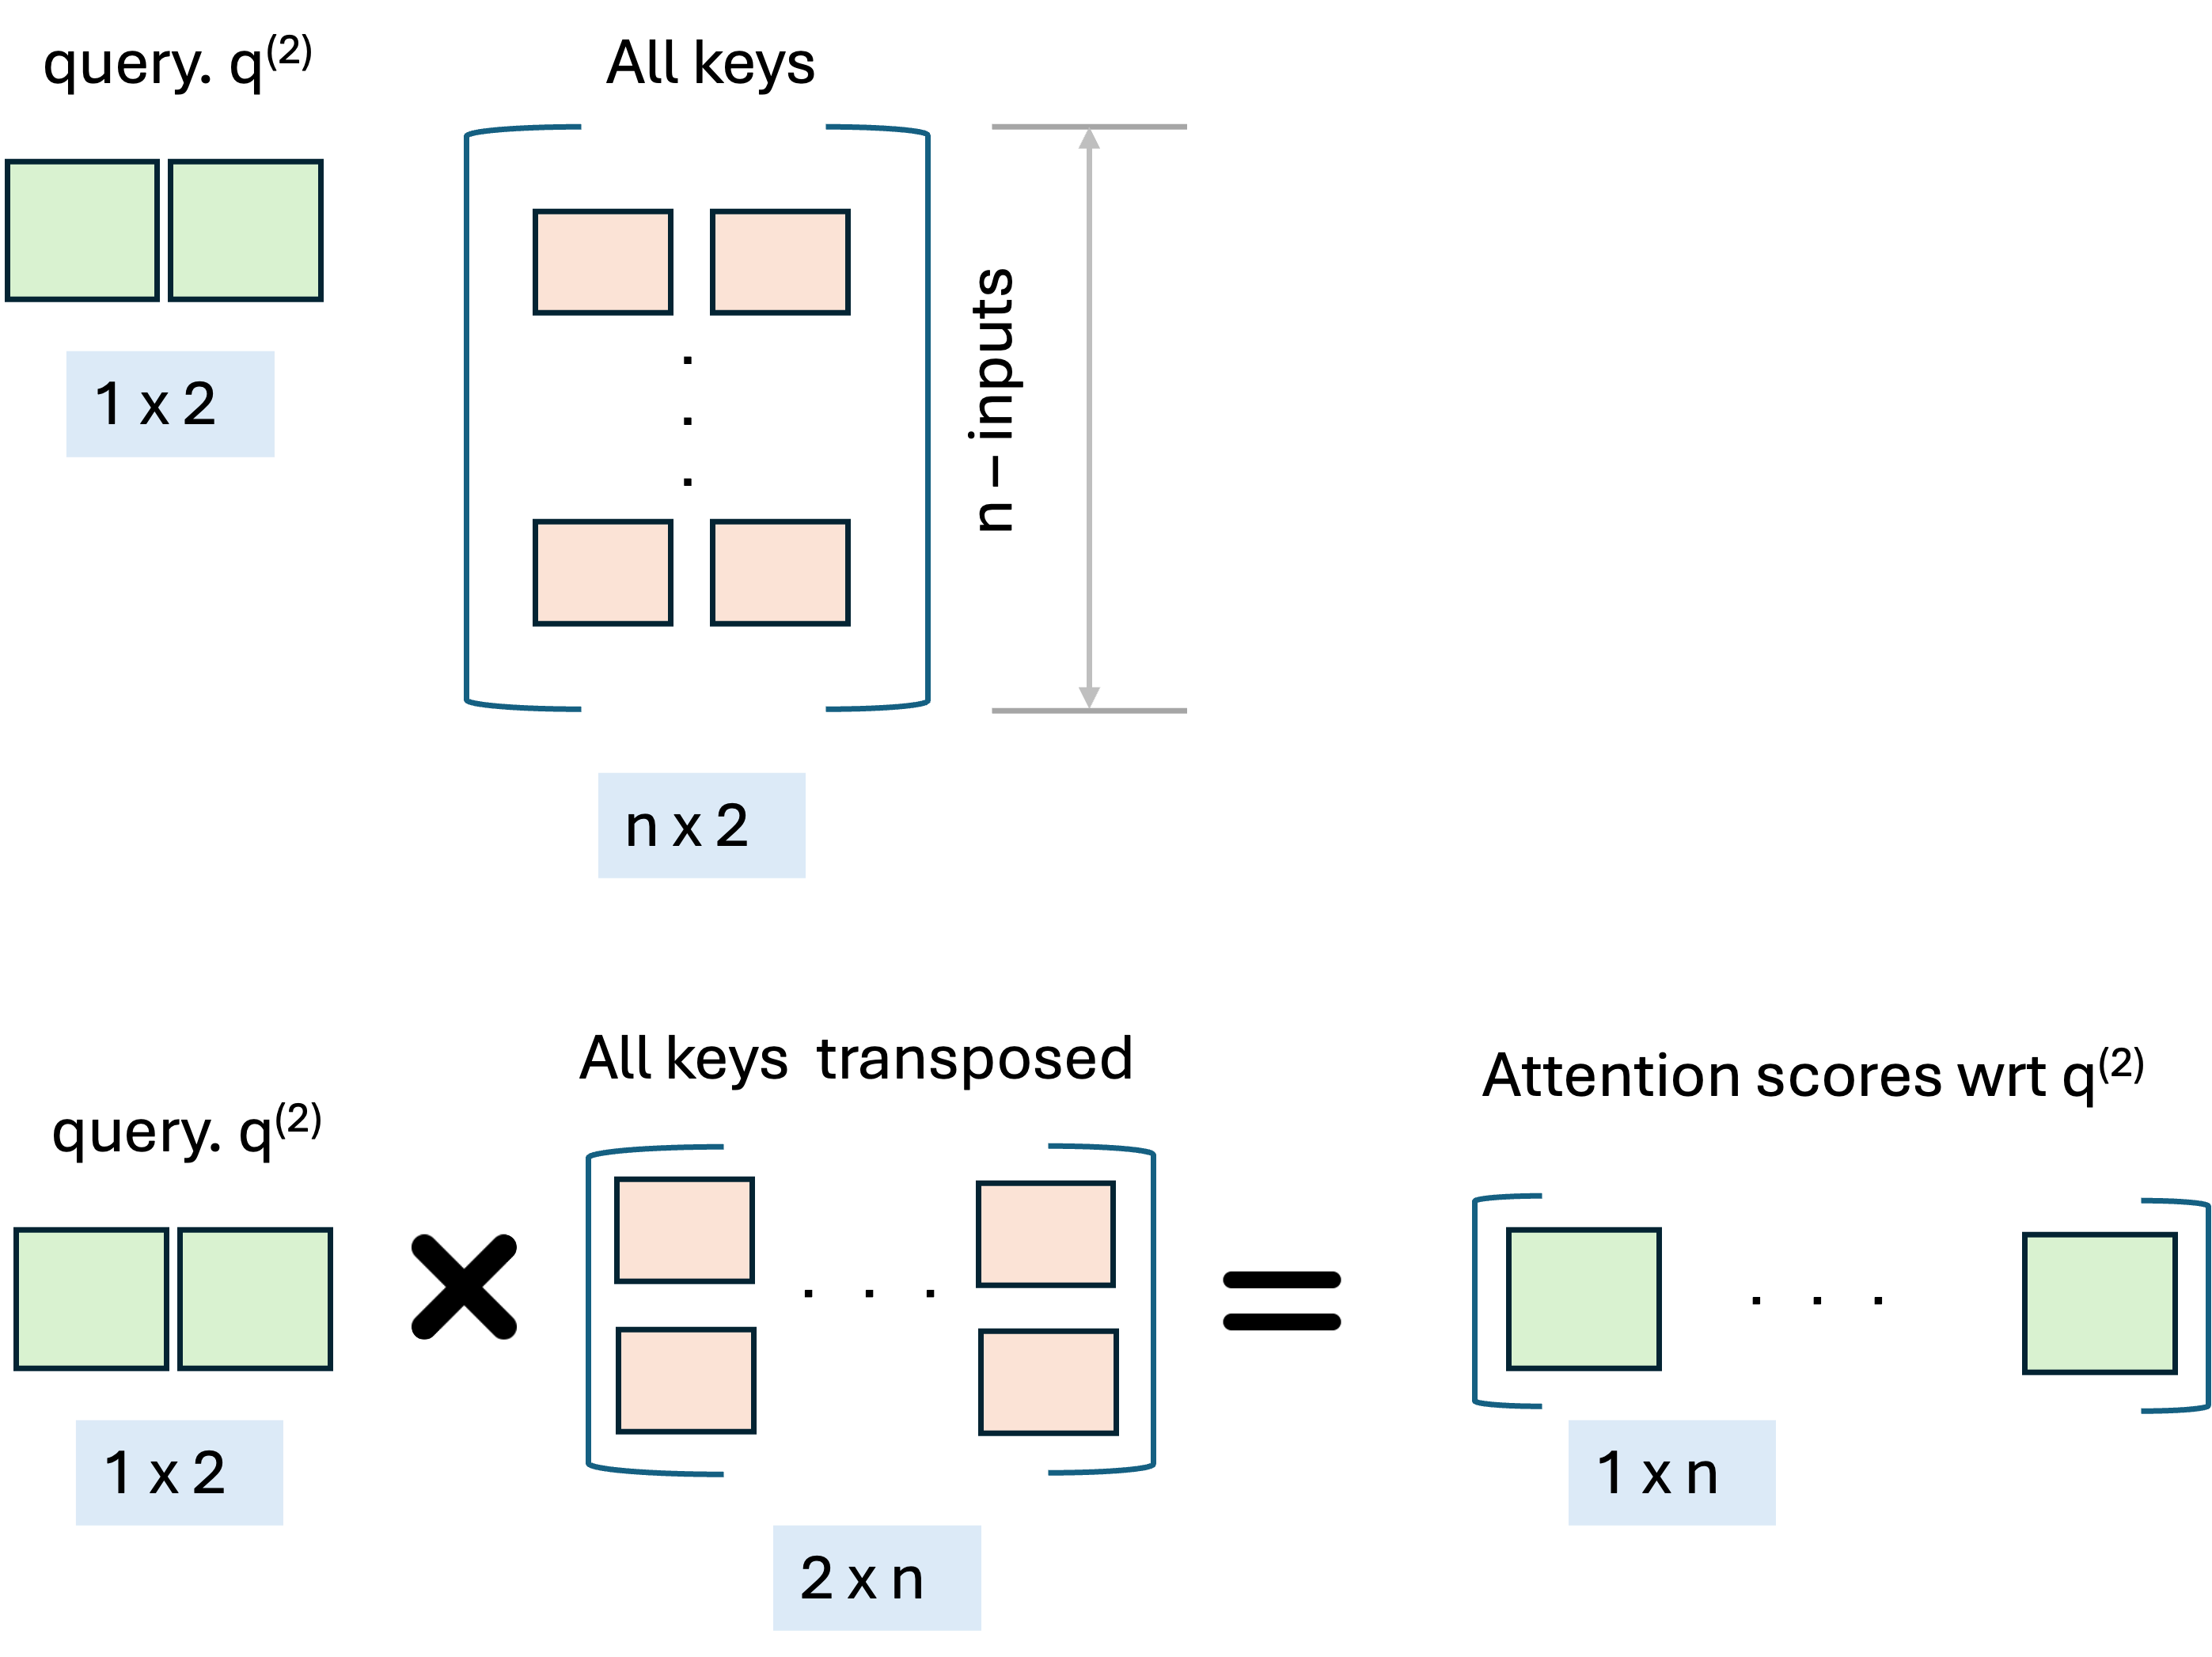

#### Compute attention scores for a given query vector 

In [11]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 1.5150])


### STEP 3 : Computing Attention Weights 

- Next, as illustrated in Figure below we compute the attention weights by scaling the attention scores and using the softmax function we used earlier.

- The difference to earlier notebook is that we now scale the attention scores by dividing them by the square root of the embedding dimension of the keys, (note that taking the square root is mathematically the same as exponentiating by 0.5)

#### Comments on scaled dot product attention 
- The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. 

- For instance, when scaling up the embedding dimension, which is typically greater than thousand for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. 

- As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. 

- These small gradients can drastically slow down learning or cause training to stagnate.


- The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.

#### The figure below depicts a schematic for the computation of the attention weights 

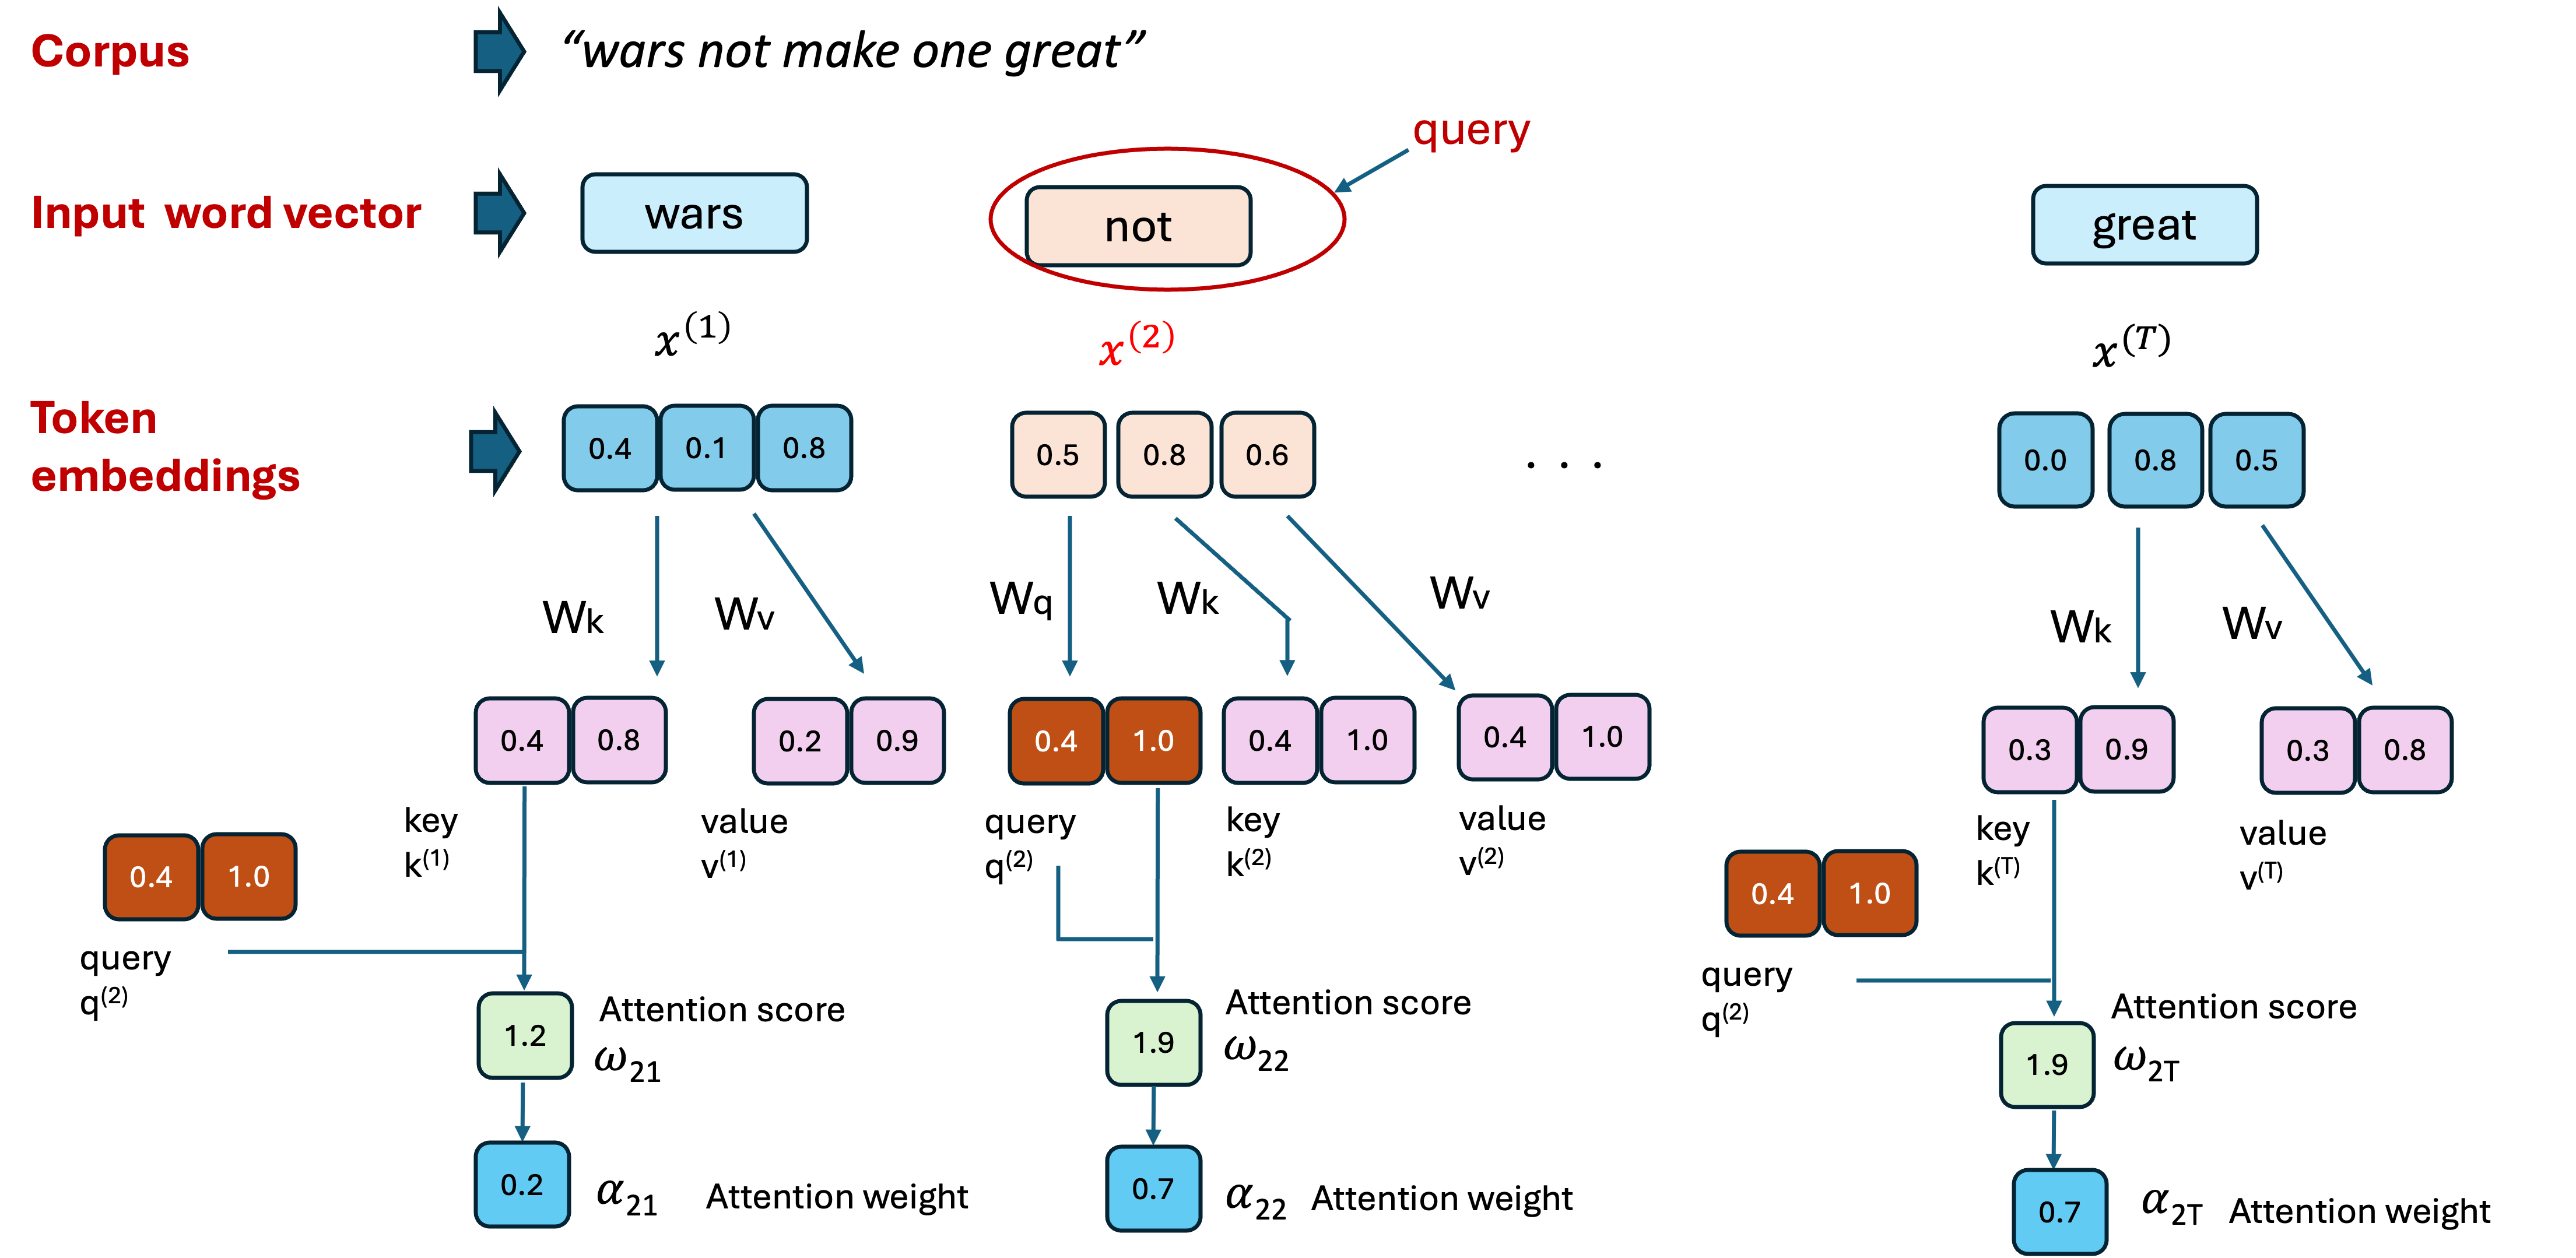

#### Compute the normalized attention scores wrt to second query vector 

In [12]:
# get the embedding dimension 
d_k = keys.shape[1]

# compute the softmax of the normalized attention scores
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)


# check 
print("Attention weights:", attn_weights_2)

# check that the sum is = 1 
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1656, 0.2500, 0.2428, 0.1447, 0.1969])
Sum: tensor(1.)


 ### STEP 4 - Compute the context vector $z^{(2)}$ 
 
 - For this we  multiply the embedded input tokens, $x^{(i)}$ with the attention weights and sum the resulting vector

#### STEP 4a Compute context vector wrt second element in input sequence

### Notes 

- We now compute the context vector as a weighted sum over the value vectors. 
- Here, the attention weights serve as a weighting factor that weighs the respective importance of each value vector.

#### The Figure below shows the schematic of the computation for context vectors 

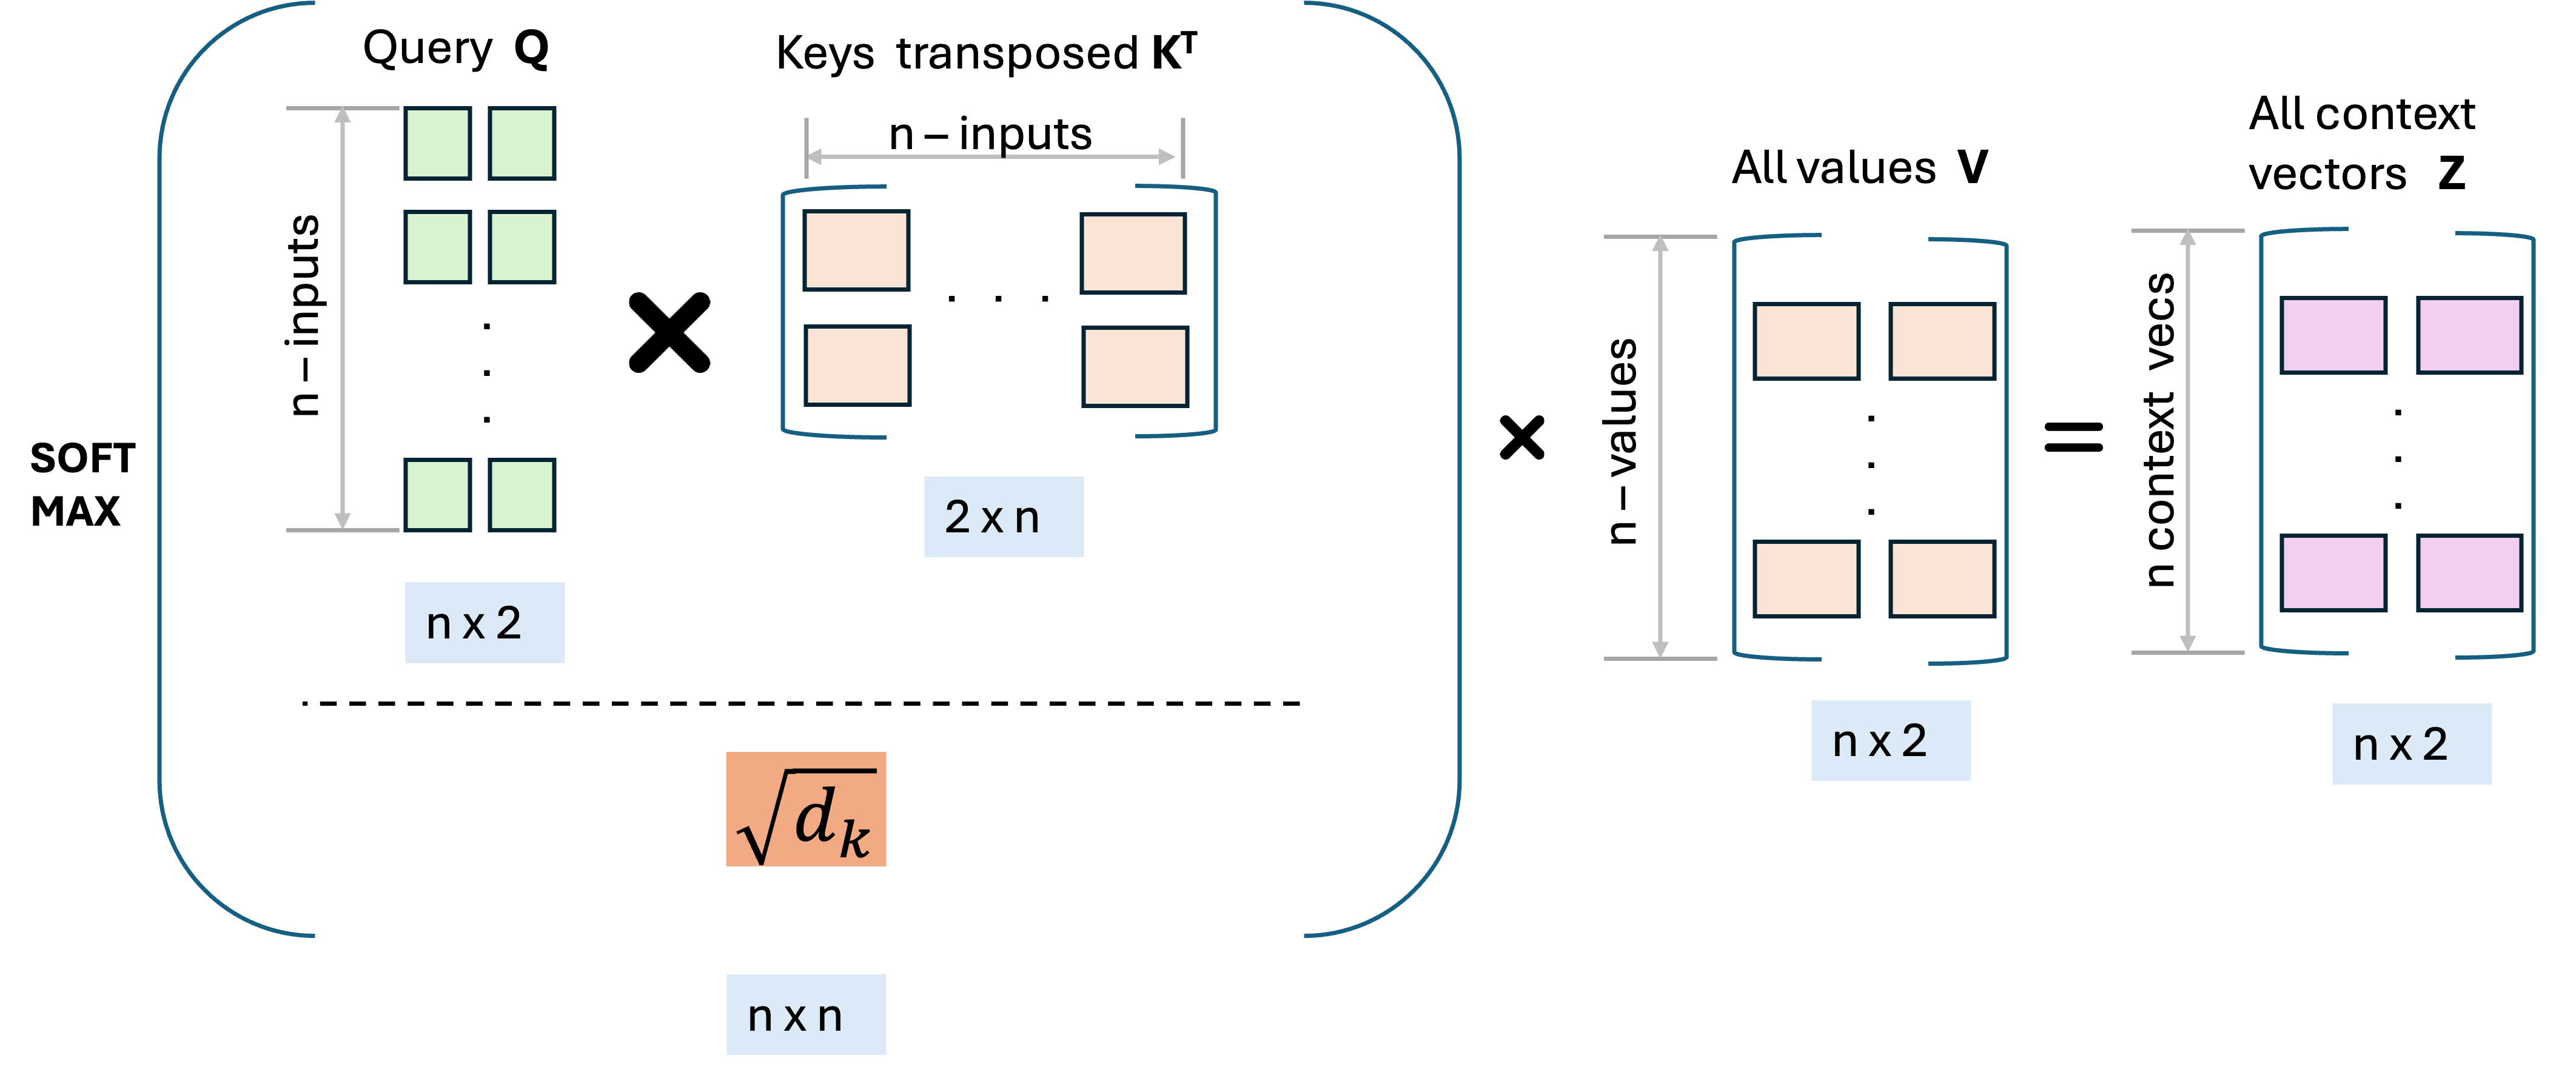

In [13]:
# compute context vector by summing the product of individual values with the attention weights wrt 2nd element 
context_vec_2 = attn_weights_2 @ values

# check 
print(context_vec_2)

tensor([0.3212, 0.8646])


### A schematic depiction of all the steps mentioned above is shown in the figure below 

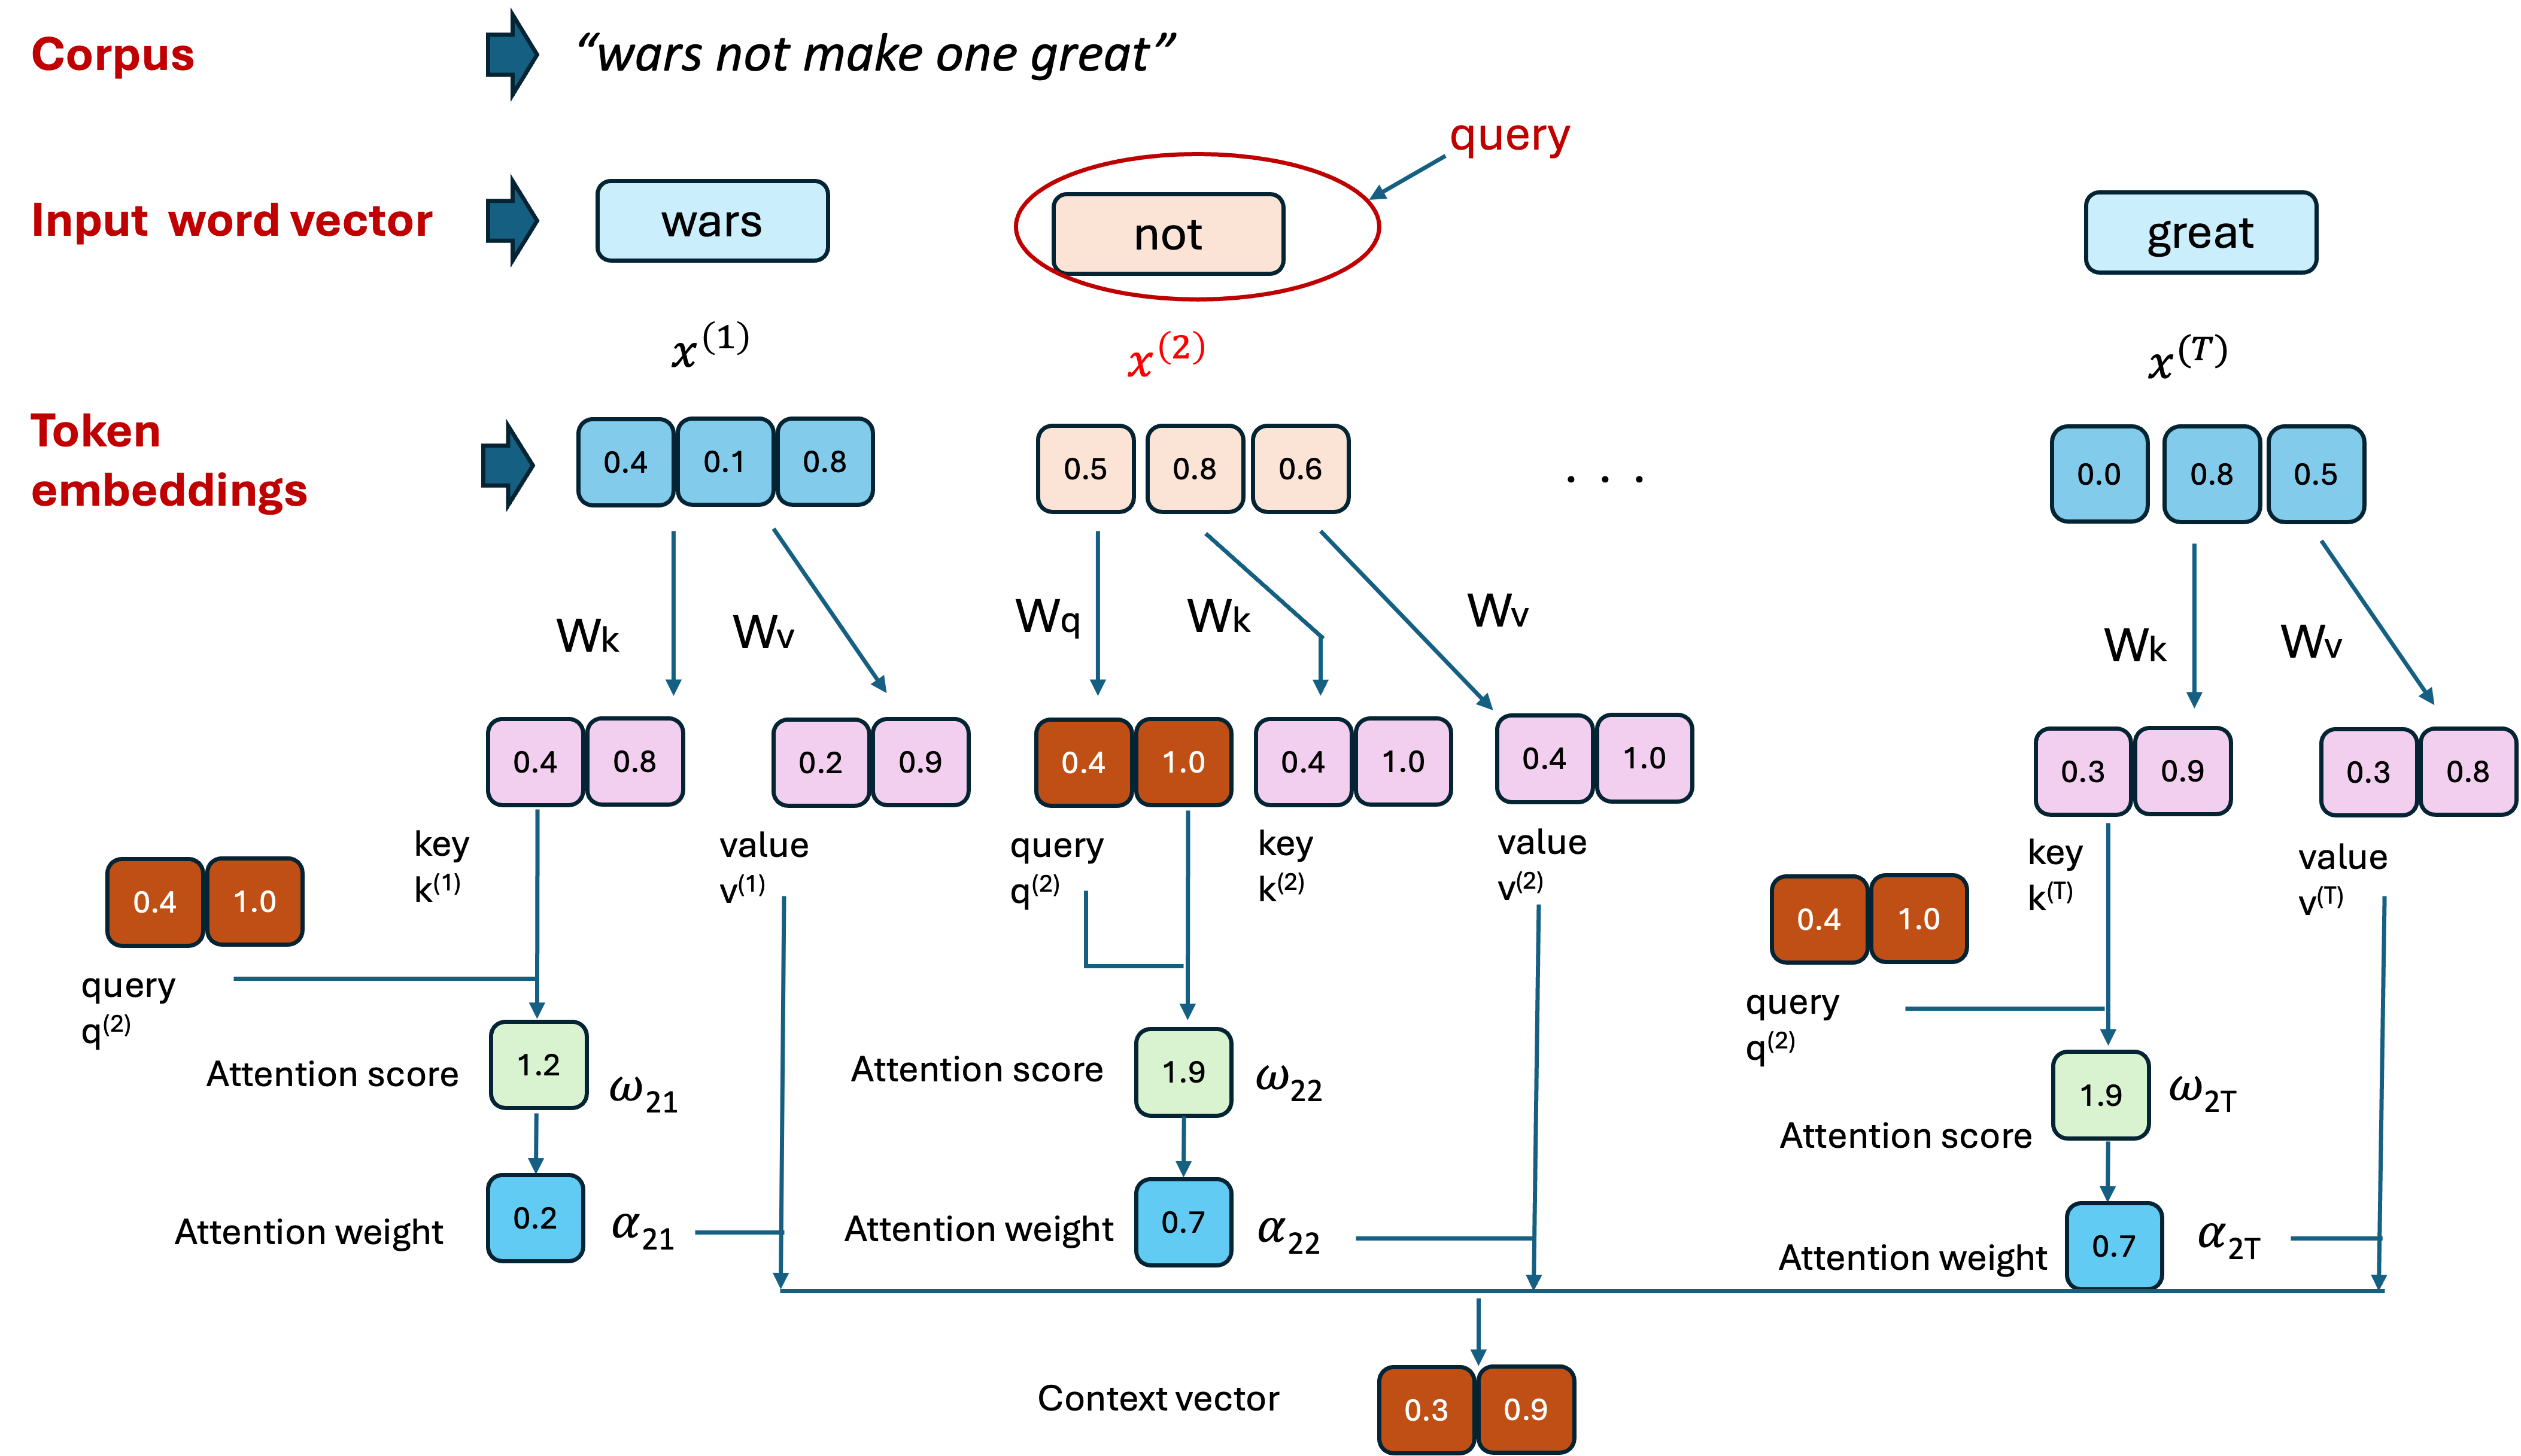

### STEP 5 - Implement a Self Attention Class - Ref Ch3 of Reference Text 

Putting it all together, we can implement the self-attention mechanism. The code snippet below is explained as follows:


**Imports**
- The code imports torch.nn from PyTorch, which provides various classes and functions to create neural network layers, including nn.Module that is inherited in this implementation.


**Class Definition: SelfAttention_v1**
- A custom class SelfAttention_v1 is defined that inherits from nn.Module, the base class for all neural network modules in PyTorch.


**Initialization Method: __init__**
- Arguments:  `d_in ` (input dimensionality) and  `d_out ` (output dimensionality).

- Superclass Initialization: `super().__init__()` calls the parent class's   `__init__ method `, ensuring proper initialization of the module.


- Weight Parameters
   -  `W_query `,  `W_key `, and  `W_value ` are defined as learnable parameters (using nn.Parameter).
   - These weights are initialized randomly using torch.rand(d_in, d_out), which creates random matrices of shape (`d_in`, `d_out`).
   -  `W_query `: Used to project the input data into the query space.
   -  `W_key `: Used to project the input data into the key space.
   -  `W_value `: Used to project the input data into the value space.
   
**Forward Method:** `forward`
- The `forward` method defines how the input tensor x passes through the model.
- Matrix Multiplications

  - `x @ self.W_key  ` : The input x is multiplied by the W_key matrix to produce the keys.
  - `x @ self.W_query` : Similarly, the input is multiplied by W_query to produce the queries.
  - `x @ self.W_value` : Lastly, the input is multiplied by W_value to produce the values.
  
  
 **Attention Scores:**
- Dot-product attention: The queries are multiplied (dot product) with the transposed keys (keys.T) to compute attention scores. 
- This results in a score that measures the relevance of each key with respect to each query.
- Shape of attn_scores: (batch_size, seq_length, seq_length)


**Scaled Softmax**

- Scaling the attention scores: The attention scores are divided by the square root of the dimensionality of the keys `(keys.shape[-1]**0.5)`. This step ensures more stable gradients, preventing the dot products from becoming too large when the input dimensionality is high.


- Softmax function: torch.softmax is applied along the last dimension  `(dim=-1) `, converting the scaled attention scores into attention weights, which represent probabilities. These weights indicate how much focus each key (and corresponding value) should receive when computing the final output.



**Context Vector**
- Weighted sum of values: The attention weights are used to compute a weighted sum of the values (values). 

- This yields the context vector, which is the output of the self-attention mechanism. It represents the combined information from all input positions, weighted by their relevance to the current position.

- The context vector is finally returned as output of self attention

#### Step 5a : define SelfAttention class 

In [14]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

#### Step 5b : Instantiate Self Attention Class 

In [15]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)


#### Step 5c : Generate Context vectors for all inputs 

In [16]:
print(sa_v1(inputs))

tensor([[0.3171, 0.8568],
        [0.3212, 0.8646],
        [0.3210, 0.8642],
        [0.3142, 0.8517],
        [0.3164, 0.8556]], grad_fn=<MmBackward0>)


## End of Notebook